#Locally adaptive factor processes:
## Algorithm test

Here, we follow the algorithm given in [Durante, Scarpa, and Dunson (2014)](http://jmlr.org/papers/volume15/durante14a/durante14a.pdf). In particular, we are following Appendix A.2.

In [1]:
using NGPtools
using Distributions
# set random seed
srand(12345);

# Load data

In [2]:
using HDF5

fid = h5open("data/labcr_test_data.jld", "r")

vars_to_read = [:y, :tobs, :xi, :psi]  # :theta, :xi, :psi, :Σ0

for v in vars_to_read
    expr = :($v = read(fid[$("/$v")]))
    eval(expr)
end
close(fid)

In [3]:
using PyPlot
plt.style[:use]("ggplot")

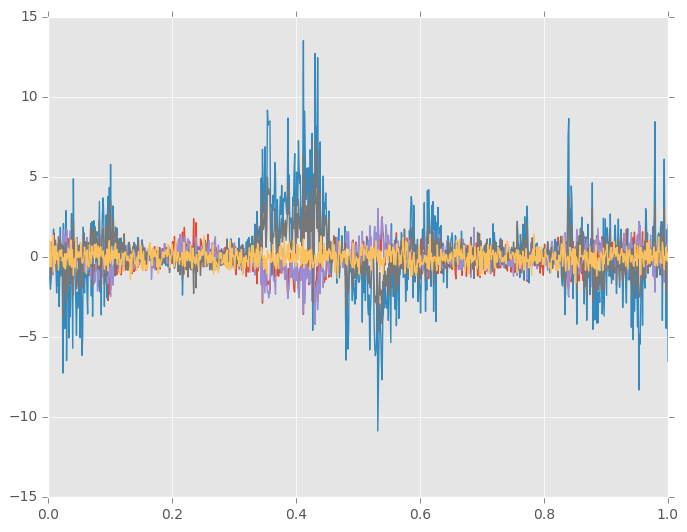

In [4]:
plot(tobs, y');

In [5]:
Np, Nt = size(y)
δ = diff(tobs)[1]

0.001

# Set up some parameters

In [6]:
NK = 2
NL = 2
Nst = NK * NL  # number of states in dynamical model
Nm = 3 * Nst  # number of states in nGP expanded model

12

In [7]:
# sampling will assume we have some variables, so let's make them

## variables to be updated
η = 0.1 * randn(NK, 1, Nt)
Θ = 0.1 * randn(Np, NL)
ϕ = rand(Gamma(3/2, 2/3), Np, NL)
ϑ = rand(Gamma(10, 1), NL)
τ = cumprod(ϑ)
Σ0 = diagm(rand(InverseGamma(1, 0.1), Np))  # 1, 0.1
σξ = 50. * ones(NL * NK)
σA = 50. * ones(NL * NK)
σψ = 50. * ones(NK)
σB = 50. * ones(NK)

## prior parameters
σμ = 100.
σα = 100.
aϵ, bϵ = 1., 0.1
aξ, bξ = 2., 5000
aA, bA = 2., 5000
aψ, bψ = 0.005, 0.005
aB, bB = 0.005, 0.005
a1, a2 = 2, 2

(2,2)

# Define sampling functions

## Sample multivariable nGP: $\Xi$

Here, the state space model is given by 

$$\begin{align}
    y_t &= Z_t \Xi + \epsilon_t \\
    \Xi &= \mathrm{vec}[(\xi_{lk})] \\
    Z_t &= [\Psi(t)^\top \otimes \Theta, 0_{p \times 2KL}] \\ 
    \epsilon_t &\sim \mathcal{N}(0, \Sigma_0) \\
    \Xi_{t + 1} &= T_t \Xi_t + R_t \Omega_t
\end{align}$$

With $\Psi$ a column vector $(K, 1)$ of means for the process, the sequences of state dynamics matrices $T_t$ and $R_t$ given by the Zhu and Dunson approximate formulae, and $\mathrm{vec}$ the concatenation by columns operator.

In [8]:
function sample_Ξ(Σ0, Θ, η, σξ, σA)
    # now these are needed for the state space model
    H = Σ0
    Z = zeros(Float64, Np, Nm, Nt)

    for t in 1:Nt
        Z[:, 1:Nst, t] = kron(slice(η, :, :, t)', Θ)
    end
    
    samp = NGPtools.sample(y, 1, Z, H, δ, σξ, σA, σμ, σα; approx=true)[:, :, 1]
    
    ξ = samp[1:Nst, :]
    Dξ = samp[(Nst + 1):2Nst, :]
    A = samp[(2Nst + 1):3Nst, :]
    
    return ξ, Dξ, A
end

sample_Ξ (generic function with 1 method)

## Sample $\sigma^2_\xi$ and $\sigma^2_A$

Just as in a previous notebook, we calculate these by conjugate updates:

$$\begin{align}
\sigma^2_\xi &\sim \mathrm{InvGa}\left(a_\xi + \frac{N_t}{2}, b_\xi + \frac{1}{2}R^2_\xi \right) \\
\sigma^2_A &\sim \mathrm{InvGa}\left(a_A + \frac{N_t}{2}, b_A + \frac{1}{2}R^2_A \right) \\
R^2_\xi &\equiv \sum_{i = 1}^{N_t - 1} \frac{\left(\xi'(t_{i + 1}) - \xi'(t_i) - A(t_i)\delta_i \right)^2}{\delta_i} \\
R^2_A &\equiv \sum_{i = 1}^{N_t - 1} \frac{\left(A(t_{i + 1}) - A(t_i) \right)^2}{\delta_i}
\end{align}$$

(Note that because we have assumed the approximate model (i.e., $\delta \ll 1$), the posterior is available in closed form as above. Zhu and Dunson, by contrast, used independence chain proposals for the two variances above.)

In [9]:
function sample_σξ(Dξ, A)
    R2ξ = sum((diff(Dξ, 2) - A[:, 1:end-1] * δ).^2, 2) / δ
    
    Nξ = size(A, 1)
    σξ = Array(Float64, Nξ)
    for idx in 1:Nξ
        σξ[idx] = sqrt(rand(InverseGamma(aξ + 0.5 * Nt, bξ + 0.5 * R2ξ[idx])))
    end
    return σξ
end

sample_σξ (generic function with 1 method)

In [10]:
function sample_σA(A)
    R2A = sum(diff(A, 2).^2, 2) / δ
    
    NA = size(A, 1)
    σA = Array(Float64, NA)
    for idx in 1:NA
        σA[idx] = sqrt(rand(InverseGamma(aA + 0.5 * Nt, bA + 0.5 * R2A[idx])))
    end
    return σA
end

sample_σA (generic function with 1 method)

## Update $\Sigma_0$

We have $\Sigma_0 = \mathrm{diag}(\sigma_1^2, \sigma_2^2, \ldots, \sigma_p^2)$ and
$$
\sigma_j^2 \sim \mathrm{InvGa}\left(a_\epsilon +\frac{N_t}{2}, b_\epsilon + 
\frac{1}{2}\sum_{i = 1}^{N_t} (y_j(t_i) - \hat{y}_j(t_i))^2  \right) \\
\hat{y}_j(t_i) = \sum_{lk} \theta_{jl}\xi_{lk}(t_i) \eta_k(t_i)
$$

In [11]:
function sample_Σ0(η, Θ, ξ)
    yhat = similar(y)

    for t in 1:Nt
        yhat[:, t] = kron(slice(η, :, :, t)', Θ) * slice(ξ, :, t)
    end
    
    SS = sumabs2(y - yhat, 2)
    
    σ2 = Array(Float64, Np)
    
    for j in 1:Np
        σ2[j] = rand(InverseGamma(aϵ + 0.5 * Nt, bϵ + 0.5 * SS[j]))
    end
    
    return diagm(σ2)
end

sample_Σ0 (generic function with 1 method)

## Update $\Psi$

Here we again approximate $\Psi$ as a nested Gaussian process with similar updates to those for $\Xi$.

In [12]:
function sample_Ψ(Σ0, Θ, ξ, σψ, σB)
    Z = zeros(Float64, Np, 3 * NK, Nt)
    H = Array(Float64, Np, Np, Nt)
    
    for t in 1:Nt
        Z_t = Θ * reshape(slice(ξ, :, t), NL, NK)
        Z[:, 1:NK, t] = Z_t
        H[:, :, t] = Z_t * Z_t' + Σ0
    end
    
    samp = NGPtools.sample(y, 1, Z, H, δ, σψ, σB, σμ, σα; approx=true, interleaved=false)[:, :, 1]
    
    Ψ = samp[1:NK, :]
    DΨ = samp[(NK + 1):2NK, :]
    B = samp[(2NK + 1):3NK, :]
    
    return Ψ, DΨ, B
end

sample_Ψ (generic function with 1 method)

In [13]:
function sample_σψ(DΨ, B)
    R2ψ = sum((diff(DΨ, 2) - B[:, 1:end-1] * δ).^2, 2) / δ
    
    Nψ = size(B, 1)
    σψ = Array(Float64, Nψ)
    for idx in 1:Nψ
        σψ[idx] = sqrt(rand(InverseGamma(aψ + 0.5 * Nt, bψ + 0.5 * R2ψ[idx])))
    end
    
    return σψ
end

sample_σψ (generic function with 1 method)

In [14]:
function sample_σB(B)
    R2B = sum(diff(B, 2).^2, 2) / δ
    
    NB = size(B, 1)
    σB = Array(Float64, NB)
    for idx in 1:NB
        σB[idx] = sqrt(rand(InverseGamma(aB + 0.5 * Nt, bB + 0.5 * R2B[idx])))
    end
    
    return σB
end

sample_σB (generic function with 1 method)

# Update mean residuals ($\eta$)

We have $\eta(t) = \psi(t) + \nu_t$ with $\nu \sim \mathcal{N}(0, \mathbb{1}_K)$

In [15]:
function sample_η(Ψ, Θ, ξ, Σ0)
    # calculate residuals
    
    for t in 1:Nt
        this_ξ = reshape(slice(ξ, :, t), NL, NK)
        yhat = Θ * this_ξ * slice(Ψ, :, t)
        Z_t = Θ * this_ξ
        Λ = eye(size(Z_t, 2)) + Z_t' * scale(1./diag(Σ0), Z_t)
        Σ = inv(Λ)
        ν = rand(MvNormal(Σ * scale(Z_t', 1./diag(Σ0)) * (y[:, t] - yhat), Σ))
        η[:, t] = Ψ[:, t] + ν
    end
    
    return η
end

sample_η (generic function with 1 method)

# Update $\Theta$

For each row of the matrix $\Theta$, we have 

$$\begin{align}
\Theta_{j\cdot} &\sim \mathcal{N}\left({\Sigma}_\theta \sum_t \tilde{\eta}(t) \sigma^{-2}_j y_j(t), 
{\Sigma}_\theta \right) \\
{\Sigma}_\theta^{-1} &= \frac{\sum_t \tilde{\eta}(t) \tilde{\eta}(t)^\top}{\sigma^2_j} +
\mathrm{diag}(\phi_{j1}\tau_1, \ldots, \phi_{jL}\tau_L) \\
\tilde{\eta}(t) &= \xi(t)\eta(t)
\end{align}$$ 

In [16]:
function sample_Θ(ξ, Σ0, ϕ, τ)

    η_tilde = Array(Float64, NL, Nt)
    for t in 1:Nt
        η_tilde[:, t] = reshape(ξ[:, t], NL, NK) * η[:, t]
    end

    ηη = η_tilde * η_tilde'

    for j in 1:Np
        sig2j = Σ0[j, j]
        Σinv = (ηη / sig2j) + diagm(squeeze(ϕ[j, :], 1) .* τ)
        
        tol = 1e-9
        try
            Σθ = inv(Σinv + scale(tol, eye(NL)))
            μ = squeeze(Σθ * (η_tilde * y[j, :]') / sig2j, 2)
            Θ[j, :] = rand(MvNormal(μ, Σθ))
        catch
            println("Σinv = ", Σinv)
            println("Θ = ", Θ)
        end
    end
    
    return Θ
end

sample_Θ (generic function with 1 method)

# Update $\phi$

Here, 

$$
\phi_{jl} \sim \mathrm{Ga}\left(2, \frac{3 + \tau_l \theta^2_{jl}}{2} \right)
$$

In [17]:
function sample_ϕ(τ, Θ)
    for j in 1:Np, l in 1:NL
        ϕ[j, l] = rand(Gamma(2, 2 / (3 + τ[l] * Θ[j, l]^2) ))
    end
    return ϕ
end

sample_ϕ (generic function with 1 method)

# Update $\vartheta$ / $\tau$

Let 
$$\tau_l^{(-h)} = \prod_{\ell \neq h}^l \vartheta_\ell$$

Then

$$\begin{align}
\vartheta_1 &\sim \mathrm{Ga}\left(a_1 + \frac{Np \cdot NL}{2}, 
1 + \frac{1}{2} \sum_l \tau_l^{(-1)} \sum_j \phi_{jl}\theta_{jl}^2\right) \\
\vartheta_h &\sim \mathrm{Ga}\left(a_2 + \frac{Np (NL - h + 1)}{2}, 
1 + \frac{1}{2} \sum_l \tau_l^{(-h)} \sum_j \phi_{jl}\theta_{jl}^2\right)
\end{align}$$

In [18]:
function sample_τ(ϕ, Θ, ϑ)
    ϕΘ = squeeze(sum(ϕ .* Θ.^2, 1), 1)

    τ_minus = cumprod(ϑ) / ϑ[1]
    ϑ[1] = rand(Gamma(a1 + 0.5 * Np * NL, 1 / (1 + 0.5 * dot(τ_minus, ϕΘ))))

    for h in 2:NL
        τ_minus = cumprod(ϑ) / ϑ[h]
        ϑ[h] = rand(Gamma(a2 + 0.5 * Np * (NL - h + 1), 1 / (1 + 0.5 * dot(τ_minus, ϕΘ))))
    end

    τ = cumprod(ϑ)
    
    return τ, ϑ
end

sample_τ (generic function with 1 method)

# Iterate

In [19]:
Niter = 10000
global ξ, Dξ, A, Ψ, DΨ, B
ξ_mat = Array(Float64, NL * NK, Nt, Niter)
ψ_mat = Array(Float64, NK, Nt, Niter)
yhat = Array(Float64, Np, Nt, Niter)
μ = Array(Float64, Np, Nt, Niter)
Σ = Array(Float64, Np, Np, Nt, Niter)

@time begin
for it in 1:Niter
    if it % 1000 == 0
        println("iteration ", it)
    end
    ξ, Dξ, A = sample_Ξ(Σ0, Θ, η, σξ, σA)
    σξ = sample_σξ(Dξ, A)
    σA = sample_σA(A)

    Ψ, DΨ, B = sample_Ψ(Σ0, Θ, ξ, σψ, σB)

    σψ = sample_σψ(DΨ, B)
    σB = sample_σB(B)

    η = sample_η(Ψ, Θ, ξ, Σ0)
        
    Σ0 = sample_Σ0(η, Θ, ξ)

    Θ = sample_Θ(ξ, Σ0, ϕ, τ)
    ϕ = sample_ϕ(τ, Θ)
    τ, ϑ = sample_τ(ϕ, Θ, ϑ)
    
    # logging
    ξ_mat[:, :, it] = ξ
    ψ_mat[:, :, it] = Ψ
    for t in 1:Nt
        ξ_this = reshape(ξ[:, t], NL, NK)
        yhat[:, t, it] = Θ * ξ_this * slice(η, :, 1, t)
        μ[:, t, it] = Θ * ξ_this * slice(Ψ, :, t)
        Σ[:, :, t, it] = Θ * ξ_this * ξ_this' * Θ' + Σ0
    end
end
end

iteration 1000
iteration 2000
iteration 3000
iteration 4000
iteration 5000
iteration 6000
iteration 7000
iteration 8000
iteration 9000
iteration 10000
4220.

# Checking output

In [20]:
burn = 2000 #1000
thin = 5
trans = min(1, 10 * thin / (Niter - burn))

0.00625

## Observed data

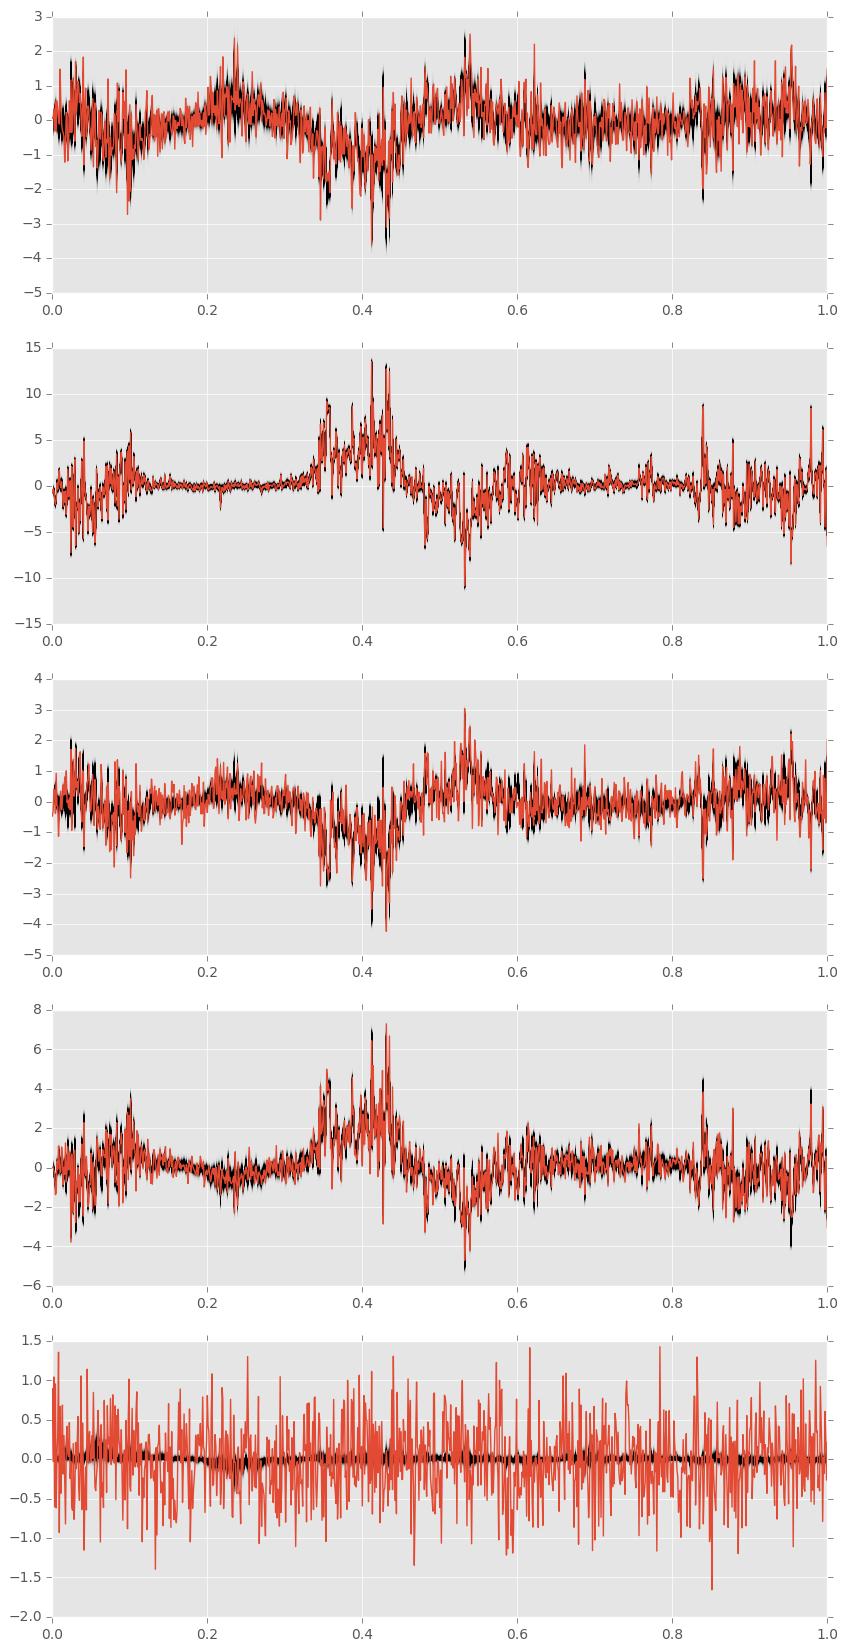

In [21]:
figure(figsize=(10, 20))

for idx in 1:Np
    subplot(Np, 1, idx)
    plot(tobs, slice(yhat, idx, :, burn:thin:size(yhat, 3)), color="black", alpha=trans)
    plot(tobs, slice(y, idx, :), zorder=5)
    xlim(tobs[1], tobs[end])
end

## Residuals

Plot $\epsilon = y - \mu$ to verify that these are normally distributed.

954305 seconds (19.40 G allocations: 2.545 TB, 12.76% gc time)


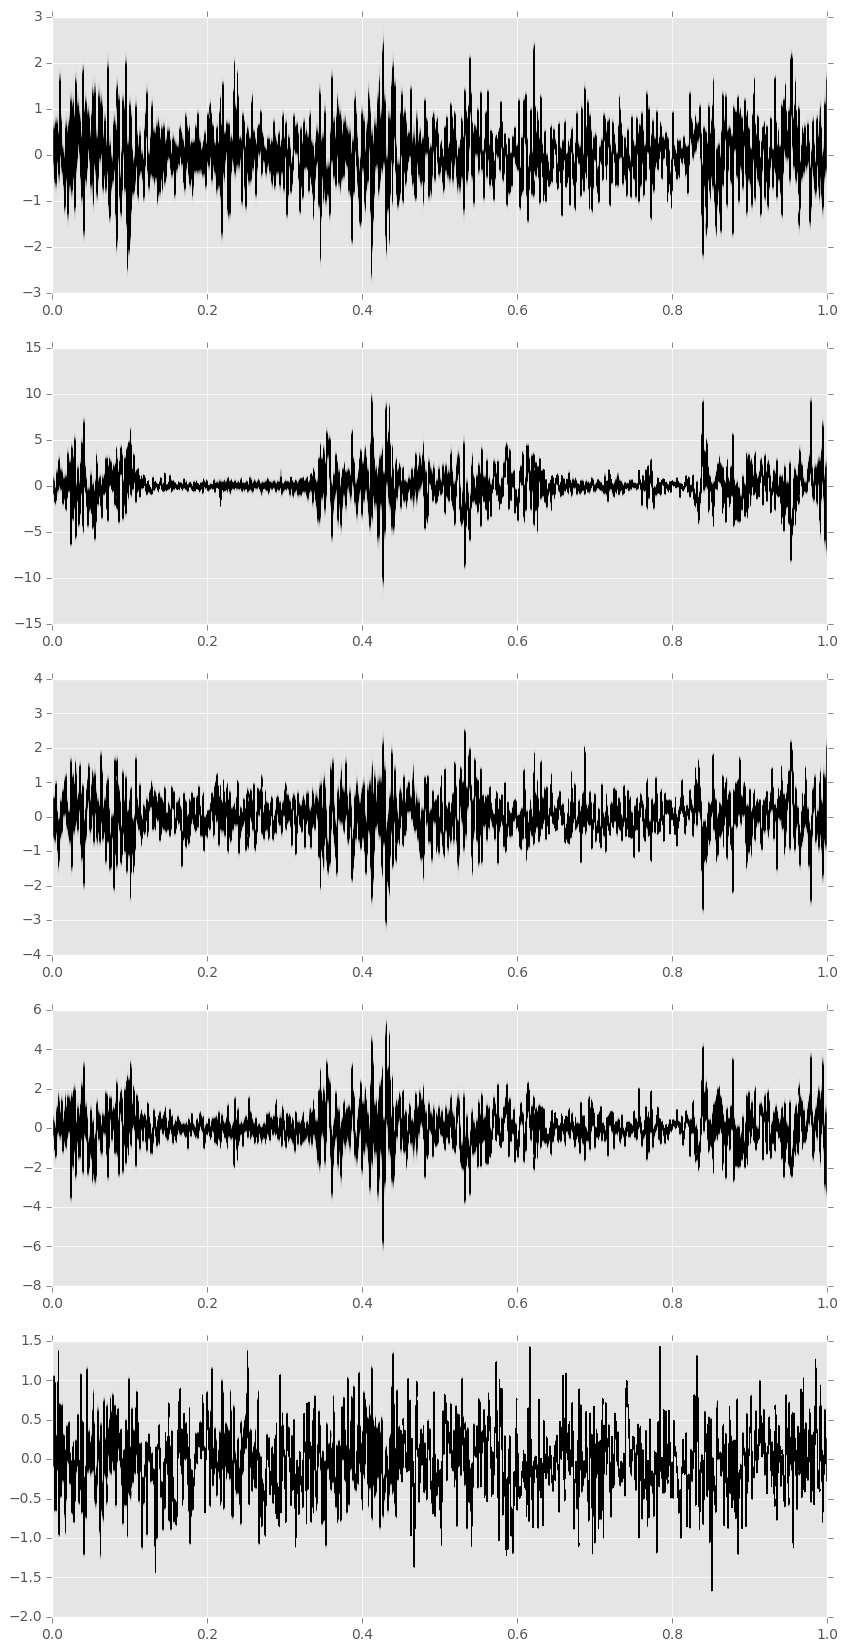

In [22]:
figure(figsize=(10, 20))

for idx in 1:Np
    subplot(Np, 1, idx)
    for ss = burn:thin:Niter
        plot(tobs, slice(y, idx, :) - slice(μ, idx, :, ss), color="black", alpha=trans)
    end
    xlim(tobs[1], tobs[end])
end

## Dictionary elements

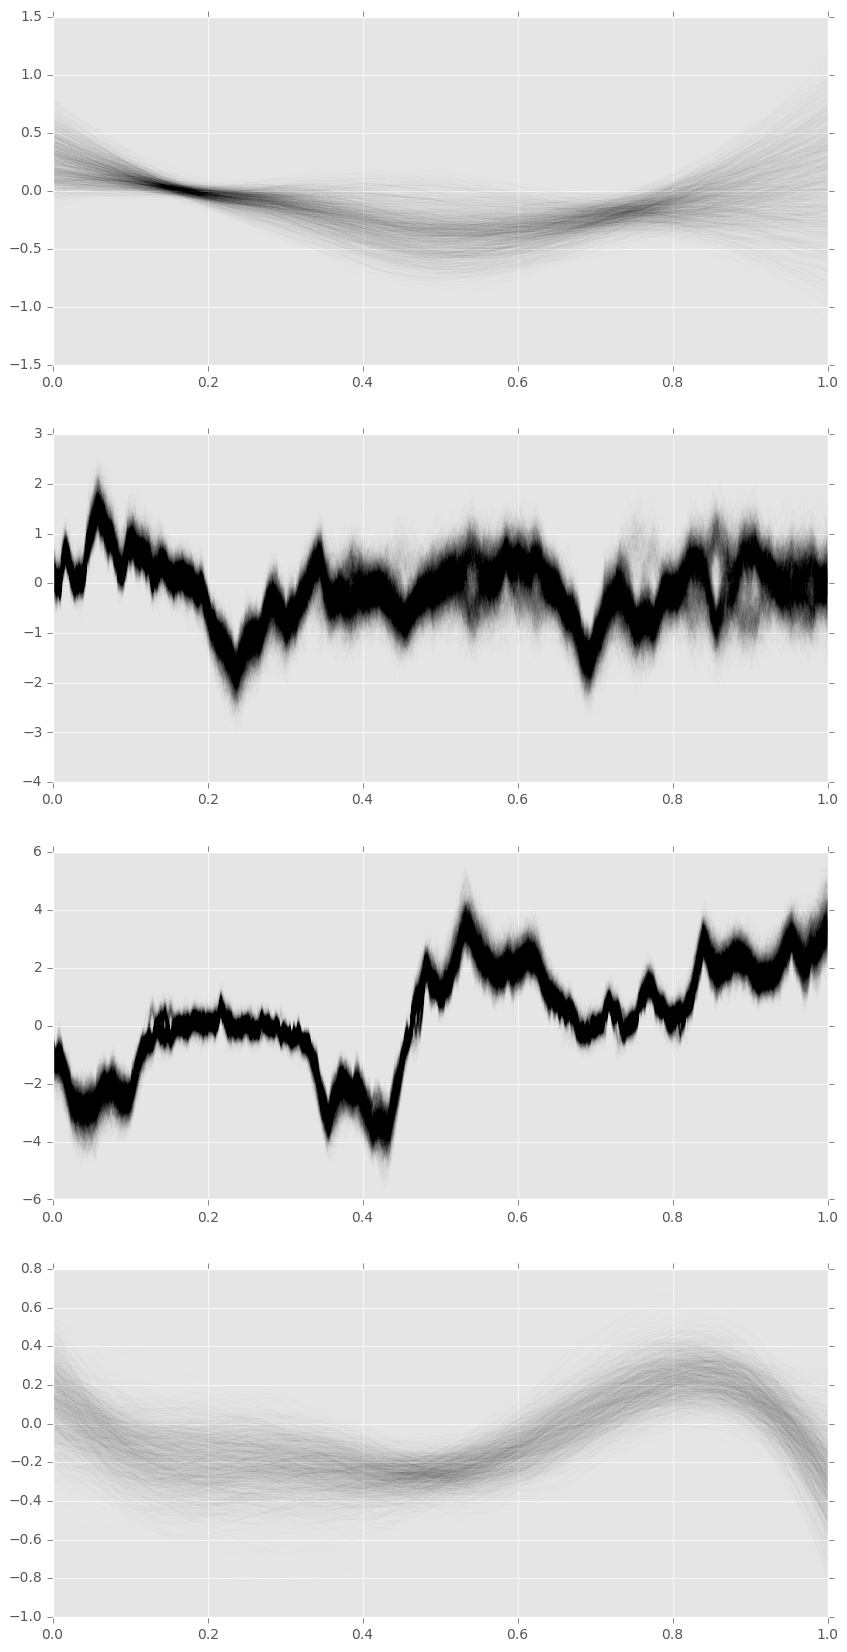

In [23]:
Nξ = NL * NK
figure(figsize=(10, 20))
for idx in 1:Nξ
    subplot(Nξ, 1, idx)
    plot(tobs, squeeze(ξ_mat[idx, :, burn:thin:end], 1), color="black", alpha=trans)
    xlim(tobs[1], tobs[end])
end

## State means

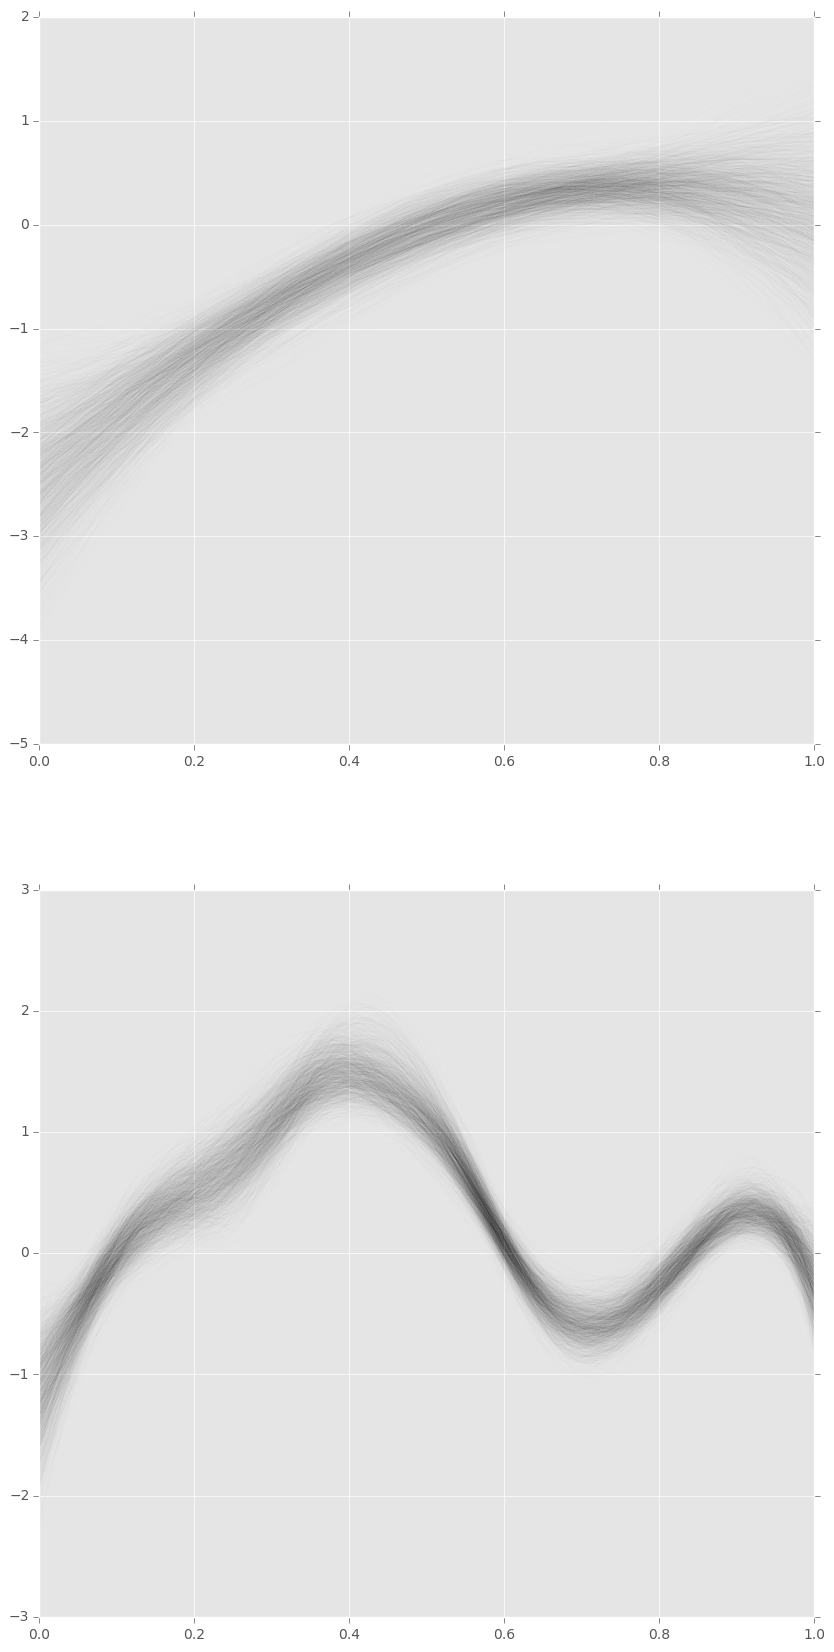

In [24]:
figure(figsize=(10, 20))
for idx in 1:NK
    subplot(NK, 1, idx)
    plot(tobs, squeeze(ψ_mat[idx, :, burn:thin:end], 1), color="black", alpha=trans)
    xlim(tobs[1], tobs[end])
end

In [25]:
σξ, σA, Σ0

([4.550050595983746,6.606519224197135,3.2301485227913886,5.4682088179170725],[4.3513184280482236,3.1554787347171858,69.5727631222036,38.970034279068486],
5x5 Array{Float64,2}:
 0.158487  0.0        0.0      0.0      0.0     
 0.0       0.0423722  0.0      0.0      0.0     
 0.0       0.0        0.17956  0.0      0.0     
 0.0       0.0        0.0      0.12368  0.0     
 0.0       0.0        0.0      0.0      0.235897)

In [26]:
Θ

5x2 Array{Float64,2}:
  0.198857     0.304231  
 -0.858226    -0.00054386
  0.235924     0.171524  
 -0.412022    -0.282822  
 -0.00108266  -0.0367063 

# Posterior means and variances

Load in ground truth from data file:

In [27]:
size(Σ_true)

LoadError: LoadError: UndefVarError: Σ_true not defined
while loading In[27], in expression starting on line 1

In [28]:
using HDF5

fid = h5open("data/labcr_test_data.jld", "r")

μ_true = read(fid["/mu"])
Σ_true = read(fid["/Sigma"])

close(fid)

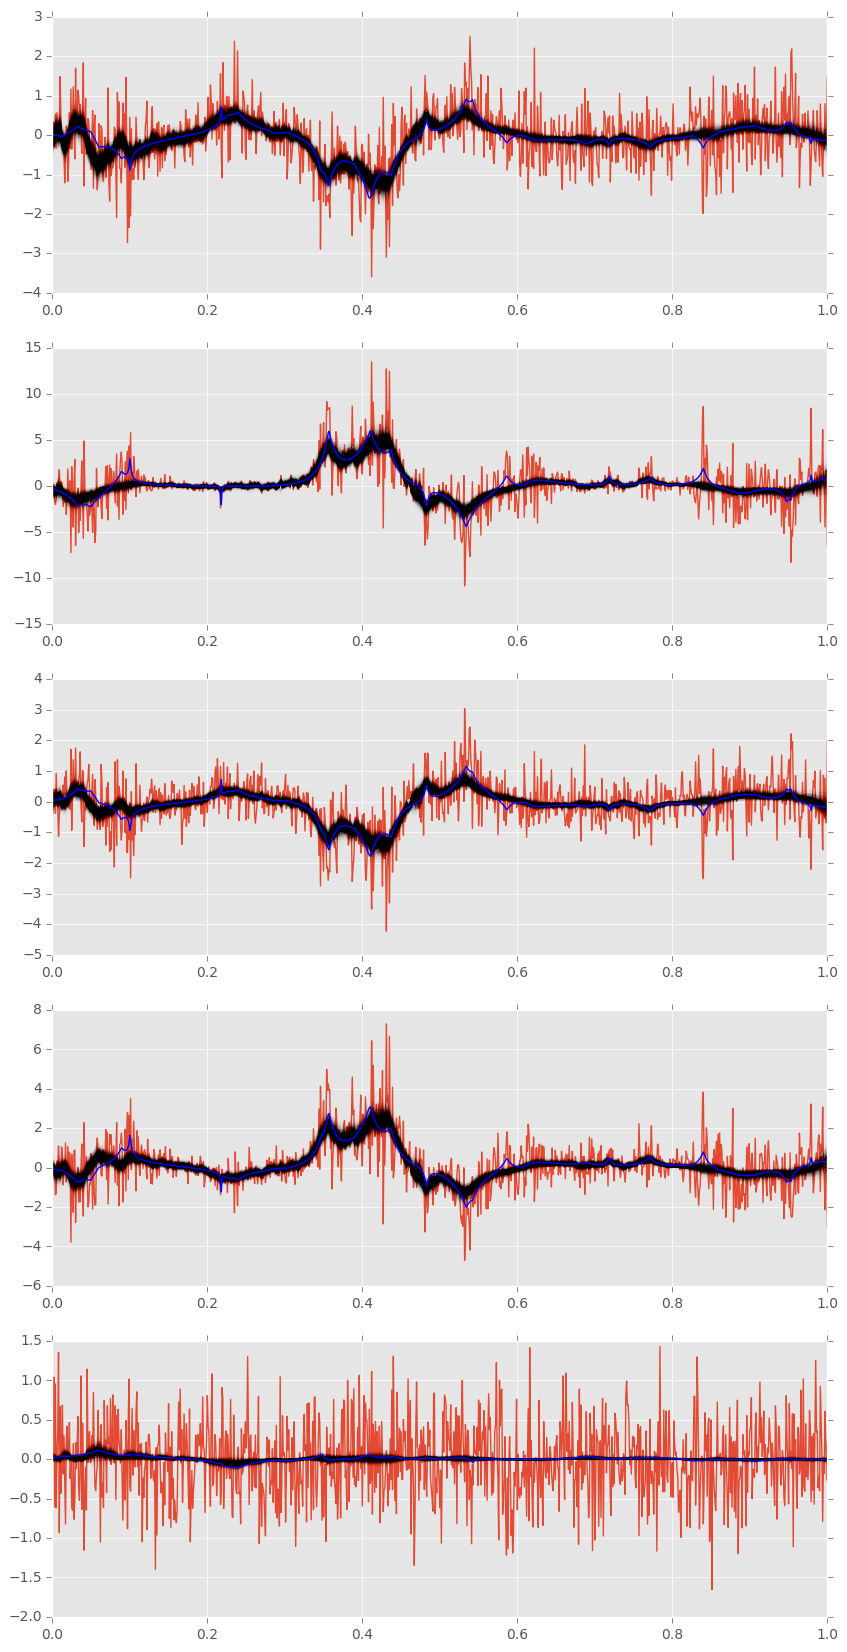

In [29]:
figure(figsize=(10, 20))
for idx in 1:Np
    subplot(Np, 1, idx)
    this_μ = squeeze(μ[idx, :, burn:thin:end], 1)
    plot(tobs, slice(y, idx, :))
    plot(tobs, this_μ, color="black", alpha=trans)
    plot(tobs, slice(μ_true, :, idx), color="blue")
    xlim(tobs[1], tobs[end])
end

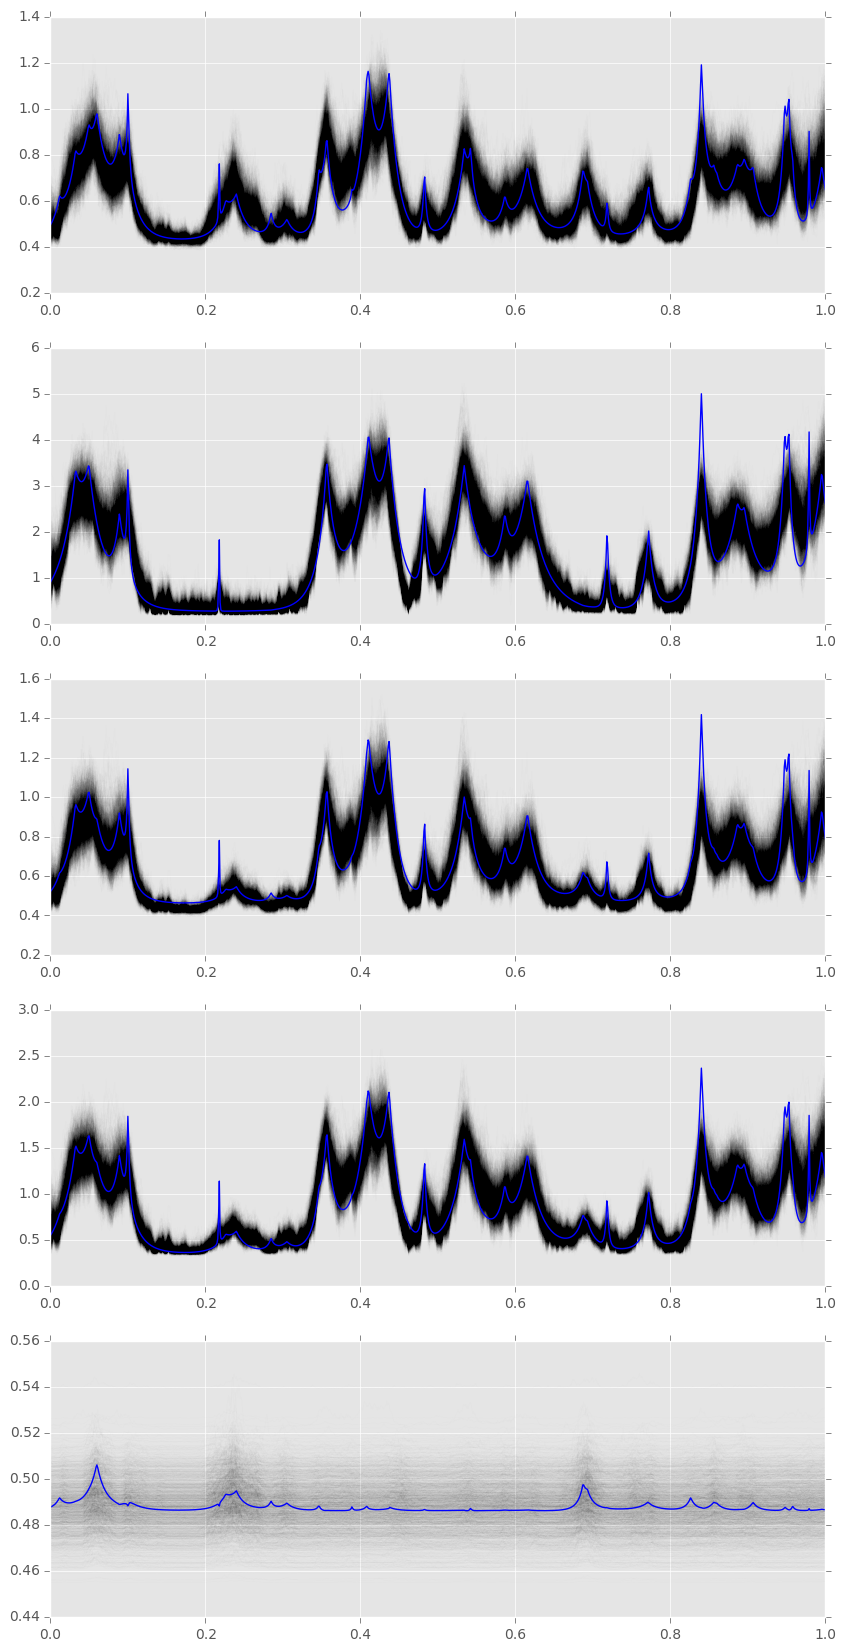

In [30]:
figure(figsize=(10, 20))
for idx in 1:Np
    subplot(Np, 1, idx)
    this_σ = sqrt(slice(Σ, idx, idx, :, burn:thin:Niter))
    plot(tobs, this_σ, color="black", alpha=trans)
    plot(tobs, sqrt(slice(Σ_true, :, idx, idx)), color="blue")
    xlim(tobs[1], tobs[end])
end